In [1]:
import warnings
warnings.simplefilter('ignore')


from tensorflow.keras.preprocessing.image import ImageDataGenerator
from os import listdir
from os.path import isfile, join
import glob

import keras 
import tensorflow as tf
print(tf.__version__)
import numpy as np
from matplotlib import pyplot as plt
from shutil import copyfile
from random import seed
from random import random

from tensorflow.keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D, Input
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers
from keras.utils import image_dataset_from_directory,load_img
from keras.applications import vgg16
from pathlib import Path

import PIL
from PIL import Image, ImageOps

from sklearn.utils import shuffle
from sklearn import metrics

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
   
from keras.callbacks import LearningRateScheduler


2024-06-18 11:23:43.276110: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-18 11:23:43.511889: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-18 11:23:44.662564: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-06-18 11:23:44.662703: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not l

2.11.0


In [2]:
seed = 10
split = 0.2
img_rows, img_cols = 150, 150
path = './flowers'
labels = [fn.split('/')[2] for fn in [join(path,f) for f in listdir(path)]]

In [3]:
labels

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [4]:

train_datagen = ImageDataGenerator(
    validation_split = split,
    rescale=1.0/255.0,
	width_shift_range=0.1, 
    height_shift_range=0.1, 
    horizontal_flip=True,
    # preprocessing_function=to_grayscale_then_rgb
)

val_datagen = ImageDataGenerator(
    validation_split = split,
    rescale=1.0/255.0,
	width_shift_range=0.1, 
    height_shift_range=0.1, 
    horizontal_flip=True,
    # preprocessing_function=to_grayscale_then_rgb
)

test_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    # preprocessing_function=to_grayscale_then_rgb
)

In [5]:
train_generator = train_datagen.flow_from_directory(
    directory = path,
    classes = labels,
    seed = seed,
    batch_size = 32, 
    class_mode='categorical',
    shuffle = True,
    target_size=(img_rows, img_cols),
    subset = 'training'
)
num_class =train_generator.num_classes

Found 3457 images belonging to 5 classes.


In [6]:
val_generator = val_datagen.flow_from_directory(
    directory = path,
    classes = labels,
    seed = seed,
    batch_size = 32, 
    class_mode='categorical',
    shuffle = True,
    target_size=(img_rows, img_cols),
    subset = 'validation'
)

Found 860 images belonging to 5 classes.


In [7]:
IMG_DIM = (img_rows, img_cols)

train_files = glob.glob('./flowers/daisy/*')
train_imgs = [tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(img, target_size=IMG_DIM)) for img in train_files]
train_imgs = np.array(train_imgs)
train_labels = [fn.split('/')[3].split('.')[0].strip() for fn in train_files]

Labels: ['1374193928_a52320eafa', '1374193928_a52320eafa', '1374193928_a52320eafa', '1374193928_a52320eafa', '1374193928_a52320eafa']


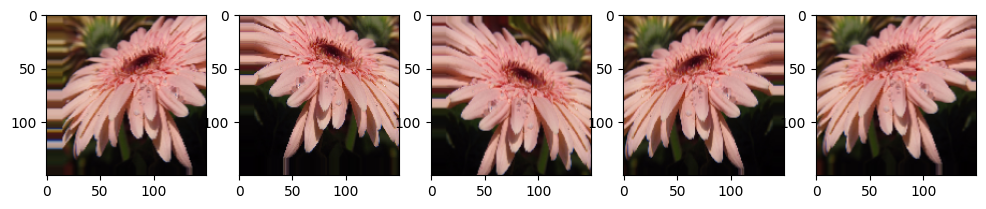

In [8]:
IMG_DIM = (img_rows, img_cols)

train_files = glob.glob('./flowers/daisy/*')
train_imgs = [tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(img, target_size=IMG_DIM)) for img in train_files]
train_imgs = np.array(train_imgs)
train_labels = [fn.split('/')[3].split('.')[0].strip() for fn in train_files]
img_id  = np.random.randint(100)
diasy_generator = train_datagen.flow(train_imgs[img_id:img_id+1], train_labels[img_id:img_id+1],
                                   batch_size=1)
diasy = [next(diasy_generator) for i in range(0,5)]
fig, ax = plt.subplots(1,5, figsize=(12, 8))
print('Labels:', [item[1][0] for item in diasy])
l = [ax[i].imshow(diasy[i][0][0]) for i in range(0,5)]

In [9]:
plt.style.use('seaborn-v0_8-dark')

def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend()
    plt.grid(True)
    
    
def plot_accuracy(history):
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.legend()
    plt.grid(True)


keras_callbacks = [
      EarlyStopping(monitor = 'loss', 
                    patience = 5, 
                    mode = 'min', 
                    min_delta=0.01),
]

callbacks_list_ = [keras_callbacks]


In [21]:
from keras.applications import vgg16
input_shape = (img_rows, img_cols, 3)

vgg16 = vgg16.VGG16(include_top=False,
                        weights='imagenet',
                        input_shape=input_shape,
                    classifier_activation='softmax')

output = vgg16.layers[-1].output
output = tf.keras.layers.Flatten()(output)
basemodel_vgg16 = Model(vgg16.input, output)

basemodel_vgg16.trainable = False
for layer in basemodel_vgg16.layers: 
    layer.trainable = False

input_shape = basemodel_vgg16.output_shape[1]

In [22]:
model_vgg16 = Sequential()
model_vgg16.add(basemodel_vgg16)
model_vgg16.add(Dense(1048, activation='relu', input_dim=input_shape))
model_vgg16.add(Dropout(0.3))
model_vgg16.add(Dense(128, activation='relu', input_dim=input_shape))
model_vgg16.add(Dense(num_class, activation='softmax'))
                 
                 
model_vgg16.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])
                 
                 
model_vgg16.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_2 (Functional)        (None, 8192)              14714688  
                                                                 
 dense_18 (Dense)            (None, 1048)              8586264   
                                                                 
 dropout_6 (Dropout)         (None, 1048)              0         
                                                                 
 dense_19 (Dense)            (None, 128)               134272    
                                                                 
 dense_20 (Dense)            (None, 5)                 645       
                                                                 
Total params: 23,435,869
Trainable params: 8,721,181
Non-trainable params: 14,714,688
_________________________________________________________________


In [23]:
model_vgg16_history = model_vgg16.fit(train_generator,
                               # steps_per_epoch=100,
                               epochs=60,
                               validation_data=val_generator, 
                               # validation_steps=20,
                               callbacks = callbacks_list_,
                               verbose=1,
                              )  

Epoch 1/60
109/109 [==============================] - 1001s 9s/step - loss: 1.0446 - accuracy: 0.6121 - val_loss: 0.7158 - val_accuracy: 0.7209
Epoch 2/60
109/109 [==============================] - 1011s 9s/step - loss: 0.6920 - accuracy: 0.7486 - val_loss: 0.6977 - val_accuracy: 0.7430
Epoch 3/60
109/109 [==============================] - 963s 9s/step - loss: 0.6164 - accuracy: 0.7749 - val_loss: 0.6012 - val_accuracy: 0.7744
Epoch 4/60
109/109 [==============================] - 942s 9s/step - loss: 0.5764 - accuracy: 0.7929 - val_loss: 0.6529 - val_accuracy: 0.7593
Epoch 5/60
109/109 [==============================] - 1010s 9s/step - loss: 0.4974 - accuracy: 0.8181 - val_loss: 0.6450 - val_accuracy: 0.7663
Epoch 6/60
109/109 [==============================] - 942s 9s/step - loss: 0.4700 - accuracy: 0.8212 - val_loss: 0.5803 - val_accuracy: 0.7884
Epoch 7/60
109/109 [==============================] - 942s 9s/step - loss: 0.4328 - accuracy: 0.8395 - val_loss: 0.6315 - val_accuracy: 0.7

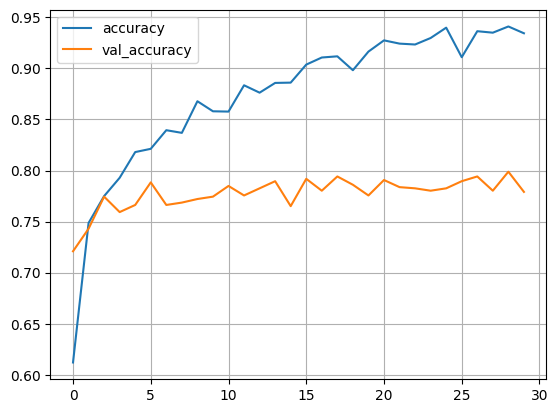

In [24]:
plot_accuracy(model_vgg16_history)

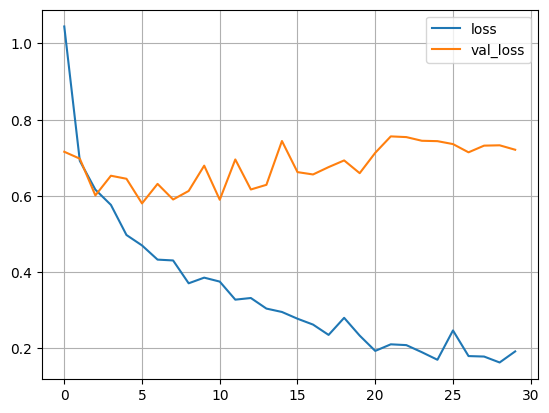

In [25]:
plot_loss(model_vgg16_history)

In [26]:
model_vgg16.save('model_vgg16_dense')

INFO:tensorflow:Assets written to: model_vgg16_dense/assets


INFO:tensorflow:Assets written to: model_vgg16_dense/assets


In [11]:
model_vgg16_dense = tf.keras.models.load_model('model_vgg16_dense')

2024-06-17 18:43:47.383542: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [67]:
from keras.applications import InceptionV3
input_shape = (img_rows, img_cols, 3)
Incept_1 = InceptionV3(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=input_shape,
    pooling=None,
    classes=num_class,
    classifier_activation="softmax"
)

output = Incept_1.layers[-1].output
output = tf.keras.layers.Flatten()(output)
basemodel_Incept_1 = Model(Incept_1.input, output)
basemodel_Incept_1.trainable = False
for layer in basemodel_Incept_1.layers: 
    layer.trainable = False

input_shape = basemodel_Incept_1.output_shape[1]

In [68]:
model_incept = Sequential()
model_incept.add(basemodel_Incept_1)
model_incept.add(Dense(1048, activation='relu', input_dim=input_shape))
model_incept.add(Dropout(0.3))
model_incept.add(Dense(128, activation='relu', input_dim=input_shape))
model_incept.add(Dense(num_class, activation='softmax'))
                 
                 
model_incept.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
                 
                 
model_incept.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 18432)             21802784  
                                                                 
 dense (Dense)               (None, 1048)              19317784  
                                                                 
 dropout (Dropout)           (None, 1048)              0         
                                                                 
 dense_1 (Dense)             (None, 128)               134272    
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 41,255,485
Trainable params: 19,452,701
Non-trainable params: 21,802,784
_________________________________________________________________


In [69]:
model_incept_history = model_incept.fit(train_generator,
                               epochs=60,
                               validation_data=val_generator, 
                                 callbacks = callbacks_list_,
                               verbose=1,
                              )  

Epoch 1/60
109/109 [==============================] - 208s 2s/step - loss: 3.1168 - accuracy: 0.5701 - val_loss: 0.7324 - val_accuracy: 0.7209
Epoch 2/60
109/109 [==============================] - 200s 2s/step - loss: 0.7854 - accuracy: 0.7220 - val_loss: 0.6576 - val_accuracy: 0.7686
Epoch 3/60
109/109 [==============================] - 173s 2s/step - loss: 0.6429 - accuracy: 0.7689 - val_loss: 0.6298 - val_accuracy: 0.7698
Epoch 4/60
109/109 [==============================] - 169s 2s/step - loss: 0.5887 - accuracy: 0.7923 - val_loss: 0.5858 - val_accuracy: 0.7849
Epoch 5/60
109/109 [==============================] - 171s 2s/step - loss: 0.4960 - accuracy: 0.8212 - val_loss: 0.6236 - val_accuracy: 0.7686
Epoch 6/60
109/109 [==============================] - 170s 2s/step - loss: 0.4829 - accuracy: 0.8198 - val_loss: 0.6272 - val_accuracy: 0.7686
Epoch 7/60
109/109 [==============================] - 170s 2s/step - loss: 0.4428 - accuracy: 0.8426 - val_loss: 0.5488 - val_accuracy: 0.8000

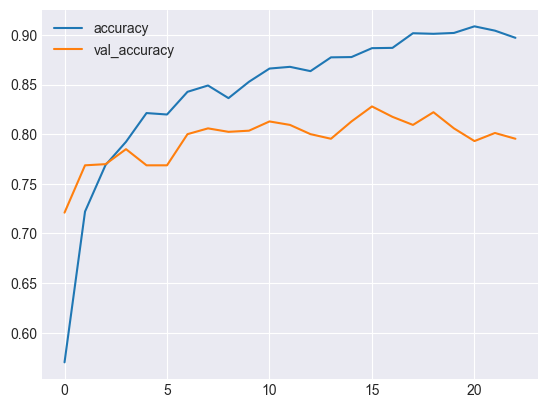

In [70]:

plot_accuracy(model_incept_history)


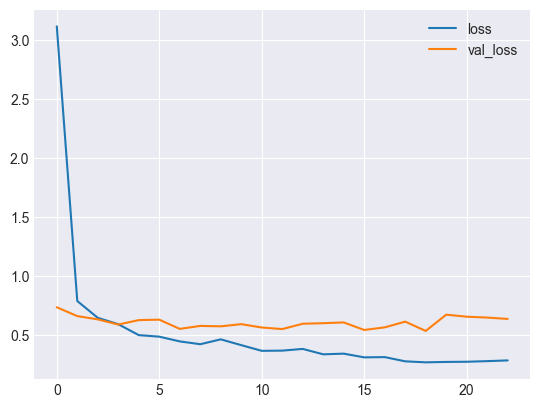

In [71]:
plot_loss(model_incept_history)

In [72]:
model_incept.save('model_incept_dense')

INFO:tensorflow:Assets written to: model_incept_dense/assets


INFO:tensorflow:Assets written to: model_incept_dense/assets


In [ ]:
model_incept_dense = tf.keras.models.load_model('model_incept_dense')

In [10]:
from keras.applications import ResNet152V2

input_shape = (img_rows, img_cols, 3)
res = ResNet152V2(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=input_shape,
    pooling=None,
    classes=num_class,
    classifier_activation="softmax"
)

output = res.layers[-1].output
output = tf.keras.layers.Flatten()(output)
basemodel_res = Model(res.input, output)
basemodel_res.trainable = False
for layer in basemodel_res.layers: 
    layer.trainable = False

input_shape = basemodel_res.output_shape[1]

2024-06-18 11:24:01.164633: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [74]:
basemodel_res.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 75, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 77, 77, 64)   0           ['conv1_conv[0][0]']       

In [11]:
model_res = Sequential()
model_res.add(basemodel_res)
model_res.add(Dense(1048, activation='relu', input_dim=input_shape))
model_res.add(Dropout(0.3))
model_res.add(Dense(128, activation='relu', input_dim=input_shape,kernel_regularizer=keras.regularizers.l1(l=0.001)))
model_res.add(Dense(num_class, activation='softmax'))
                 
                 
model_res.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
                 
                 
model_res.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 51200)             58331648  
                                                                 
 dense (Dense)               (None, 1048)              53658648  
                                                                 
 dropout (Dropout)           (None, 1048)              0         
                                                                 
 dense_1 (Dense)             (None, 128)               134272    
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 112,125,213
Trainable params: 53,793,565
Non-trainable params: 58,331,648
_________________________________________________________________


In [12]:
model_res_history = model_res.fit(train_generator,
                               epochs=60,
                               validation_data=val_generator, 
                                 callbacks = callbacks_list_,
                               verbose=1,
                              )  

Epoch 1/60
109/109 [==============================] - 661s 6s/step - loss: 6.1422 - accuracy: 0.6306 - val_loss: 3.5708 - val_accuracy: 0.6930
Epoch 2/60
109/109 [==============================] - 642s 6s/step - loss: 3.0041 - accuracy: 0.7657 - val_loss: 2.5623 - val_accuracy: 0.7965
Epoch 3/60
109/109 [==============================] - 660s 6s/step - loss: 2.3258 - accuracy: 0.8016 - val_loss: 2.1073 - val_accuracy: 0.8081
Epoch 4/60
109/109 [==============================] - 654s 6s/step - loss: 1.8695 - accuracy: 0.8302 - val_loss: 1.8010 - val_accuracy: 0.8314
Epoch 5/60
109/109 [==============================] - 684s 6s/step - loss: 1.5684 - accuracy: 0.8574 - val_loss: 1.6097 - val_accuracy: 0.8221
Epoch 6/60
109/109 [==============================] - 721s 7s/step - loss: 1.3412 - accuracy: 0.8765 - val_loss: 1.4968 - val_accuracy: 0.8093
Epoch 7/60
109/109 [==============================] - 670s 6s/step - loss: 1.1319 - accuracy: 0.8990 - val_loss: 1.3270 - val_accuracy: 0.8291

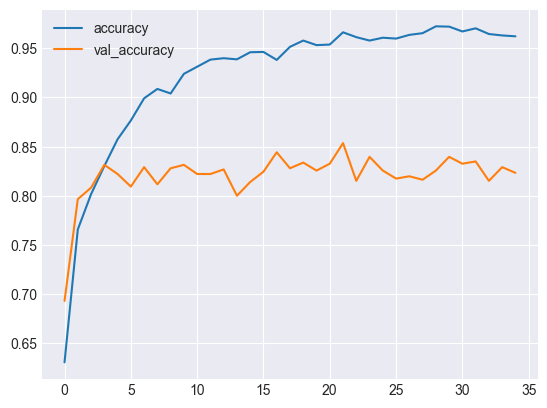

In [13]:
plot_accuracy(model_res_history)

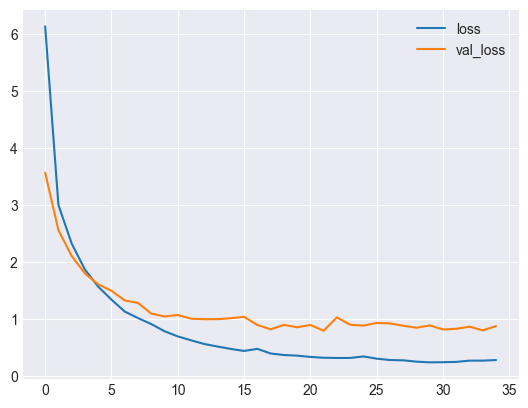

In [14]:
plot_loss(model_res_history)

In [15]:
model_res.save('model_res_dense')

INFO:tensorflow:Assets written to: model_res_dense/assets


INFO:tensorflow:Assets written to: model_res_dense/assets


In [16]:
model_res_dense = tf.keras.models.load_model('model_incept_dense')

In [22]:
from sklearn.utils import shuffle
pics = list()
pics_arr = list()
p_class = list()
files = list()

data_dir = Path("flowers")



# plt.figure(figsize=(20,5))
for idx, folder in enumerate(data_dir.glob('[!LICENSE]*')):
    for file in shuffle(list(data_dir.glob(folder.name+'/*')))[0:150]:
        files.append(file)
    
files = shuffle(files)
    
test_imgs = [tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(str(img), target_size=IMG_DIM)) for img in files]
test_imgs = np.array(test_imgs)
test_labels = [fn.parts[1] for fn in files]

# Standardize
test_imgs_scaled = test_imgs.astype('float32')
test_imgs_scaled /= 255   
    

In [20]:
def model_report(model,test_img):
    predicts = model.predict(test_img)
    predicts_labels = [ labels[np.argmax(score)] for score in predicts ]
    
    
#     #Preview Predicts Image
    fig1, ax1 = plt.subplots(1,5,figsize=(25,5))
    ax1= ax1.flatten()
    fig1.suptitle("Image with Predicted Labels", fontsize=18)
    l1 = [ax1[i].imshow(test_img[i]) for i in range(5)]
    l1_label = [ax1[i].set_xlabel(predicts_labels[i]) for i in range(5)]
    
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=metrics.confusion_matrix(test_labels,predicts_labels,normalize='true'),display_labels=labels)
    disp.plot()
    plt.show()
  
                
                


24/24 [==============================] - 8s 316ms/step


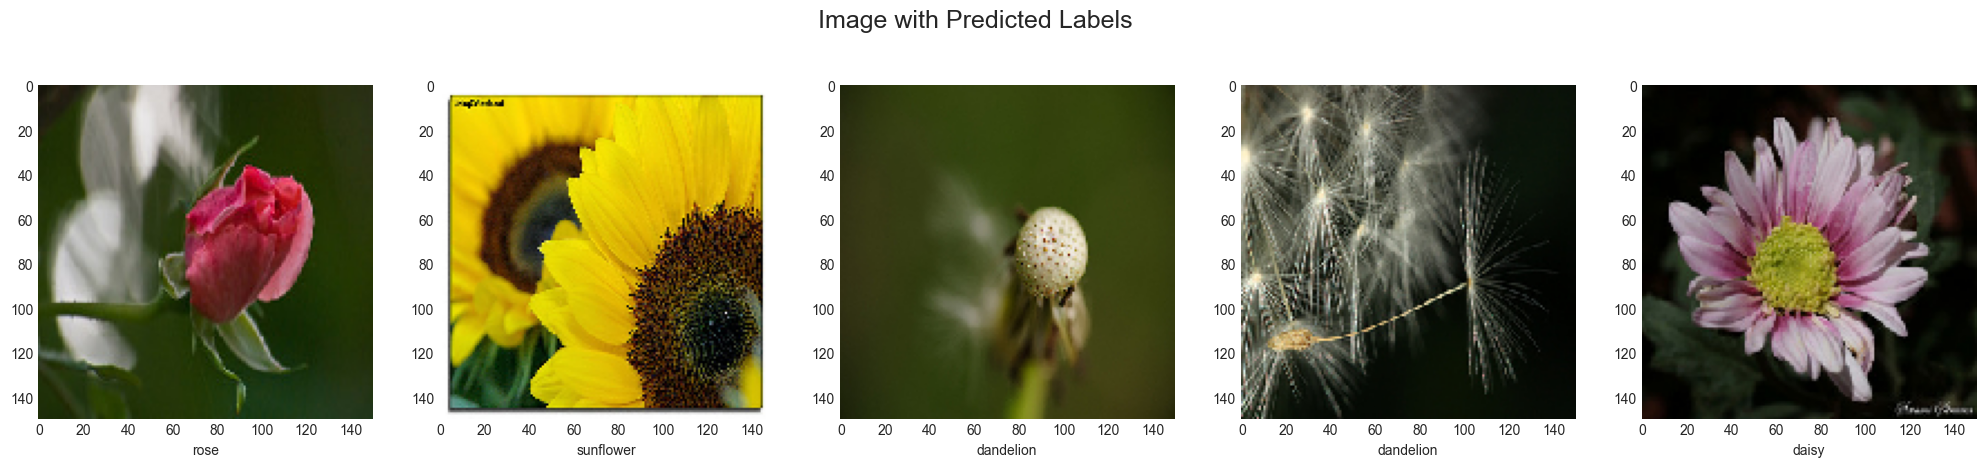

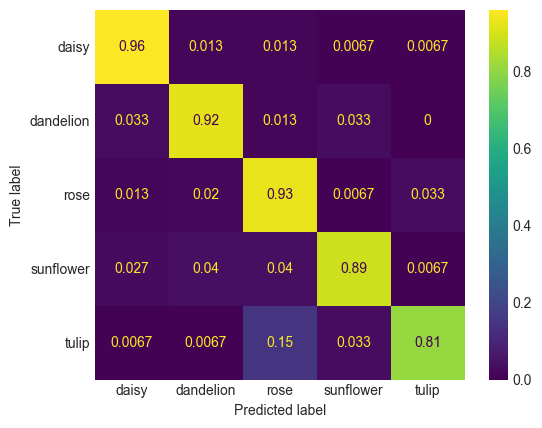

In [23]:
model_report(model_res_dense,test_imgs_scaled)